In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from argparse import Namespace
import torch
from train_pixart_layoutcontrolnet_hf2 import load_pretrained, load_data, masktensor_to_colorimage, make_image_grid
import json
from pathlib import Path
from torchvision import transforms
import pickle


/USERSPACE/lukovdg1/venvs/sd3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:

DEFAULTPATH = "/USERSPACE/lukovdg1/pixart-sigma/train_scripts/control_experiments_v2/pixart_coco_layoutcontrolnet2_attnctrl_noemb_noglobal"
# DEFAULTPATH = "/USERSPACE/lukovdg1/pixart-sigma/train_scripts/control_experiments_v2/pixart_coco_layoutcontrolnet2_bbox_attnctrl_noattnemb_noglobal"
DEFAULTDEVICE = 2

In [4]:
expdir, device = DEFAULTPATH, DEFAULTDEVICE

device = torch.device("cuda", device)
pipe, tokenizer, _, args = load_pretrained(Path(expdir), device=device)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it]


torch.Size([1, 512, 64, 64])


/USERSPACE/lukovdg1/pixart-sigma/train_scripts/train_pixart_layoutcontrolnet_hf2.py:584: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  controlencoder.load_state_dict(torch.l

Loading from:  /USERSPACE/lukovdg1/pixart-sigma/train_scripts/control_experiments_v2/pixart_coco_layoutcontrolnet2_bbox_attnctrl_noattnemb_noglobal/saved-10000


/USERSPACE/lukovdg1/pixart-sigma/train_scripts/train_pixart_layoutcontrolnet_hf2.py:614: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(savedpaths[0] / "contr

loaded pipeline components, loading pipeline


Loading pipeline components...: 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]


In [5]:
ds, dl = load_data(args, tokenizer, split="val")

loading captions
loading instances
Creating examples


100%|██████████| 5000/5000 [00:00<00:00, 352054.26it/s]

Size stats:
{384: 1937, 448: 1792, 512: 343}
Retained examples: 3342
Too many regions: 121
Too few regions: 609
Too small: 928


In [6]:
print(pipe.device)
pipe.to(device)
print(pipe.transformer.device)

cuda:2
cuda:2


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


0 A person standing by a stove in a kitchen.
['black oven with red light.', 'cup', 'a man with curly hair wearing a white apron and black pants.', 'old-fashioned wood-burning stove.', 'bottle', 'cup', 'black metal sink in a wooden cabinet.', 'bowl', 'wooden table with various food items and utensils on it.', 'a large, round, wooden bowl.']


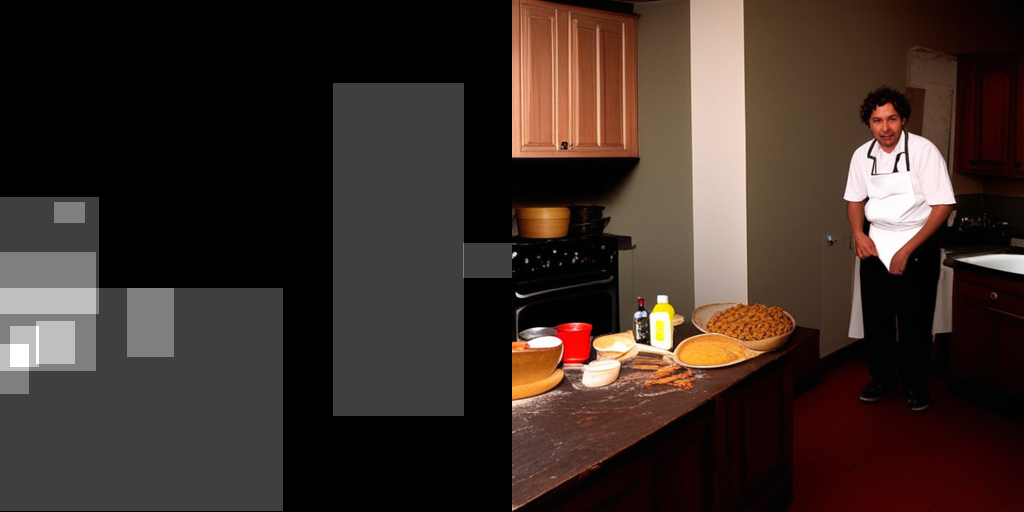

100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


1 People walking past a homeless man begging on a city street
['handbag', 'a bearded man in a white t-shirt and black pants.', 'the traffic light is red.', 'woman with long brown hair wearing a green tank top and black skirt.']


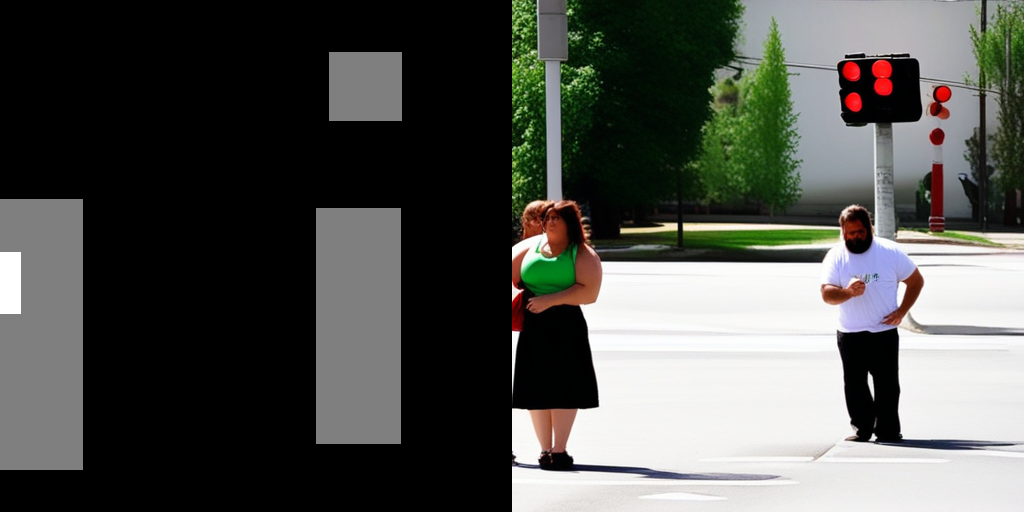

100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


2 a bike sits parked next to a street 
['blue bicycle with black tires and silver frame.', 'car', 'dark colored sedan with red tail light.', 'car']


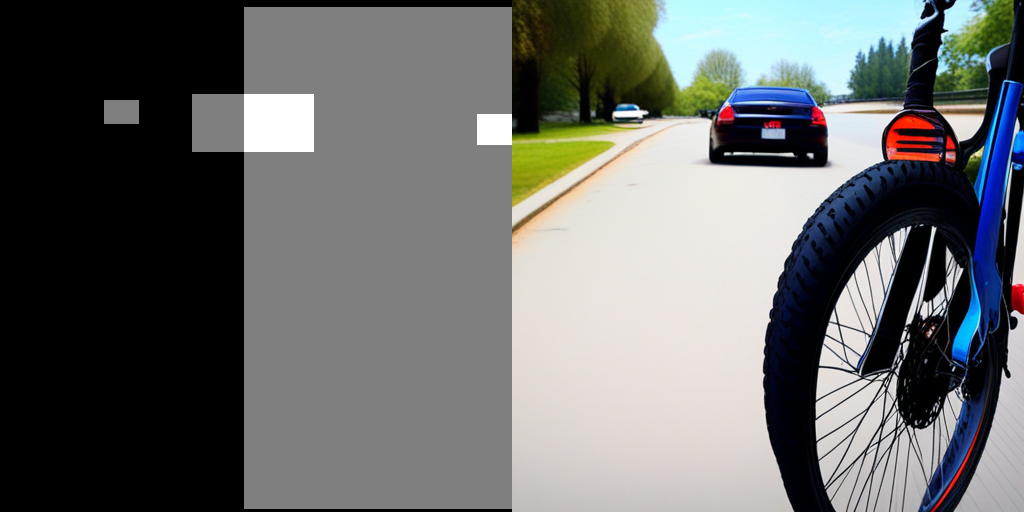

100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


3 A row of white toilets sitting on top of a dirt ground.
['toilet', 'broken toilet with missing lid.', 'white toilet with wooden seat.', 'old, dirty, and broken toilet.', 'broken toilet with missing lid.', 'old, dirty, and broken toilet.', 'old, dirty, and broken toilet.', 'broken toilet in the grass.', 'toilet is white and old.', 'broken toilet with no lid.']


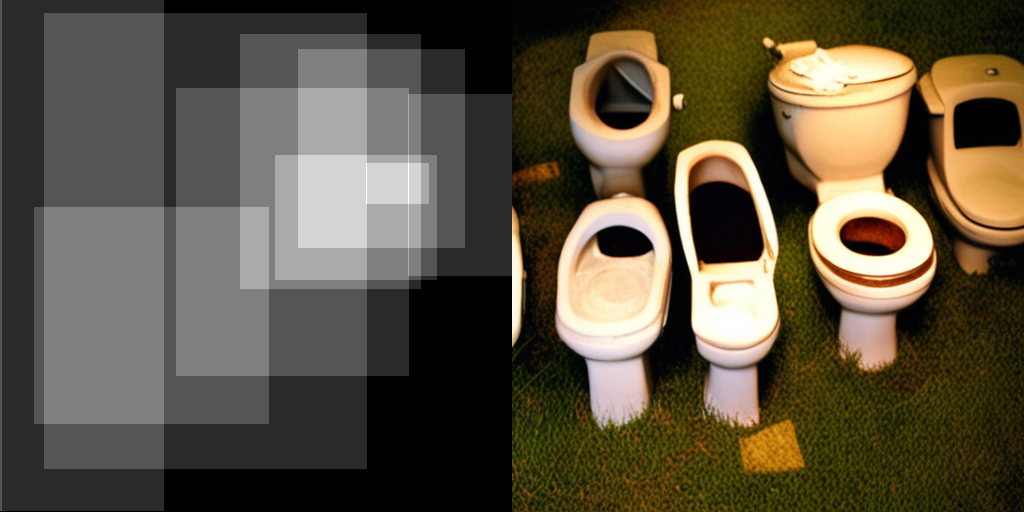

100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


4 A bunch of bikers are gathered on a city street. 
['a young man with dark hair wearing a white shirt and black pants.', 'black and blue motorcycle.', 'man wearing a helmet and a white shirt.', 'person', 'bicycle', 'black car with tinted windows.', 'man wearing a black helmet and a white shirt.', 'black and red motorcycle.', 'a man wearing a black jacket with red trim and sunglasses.', 'black and red motorcycle.', 'car', 'truck', 'person wearing a black helmet and a grey jacket.', 'person', 'person', 'person', 'car', 'car']


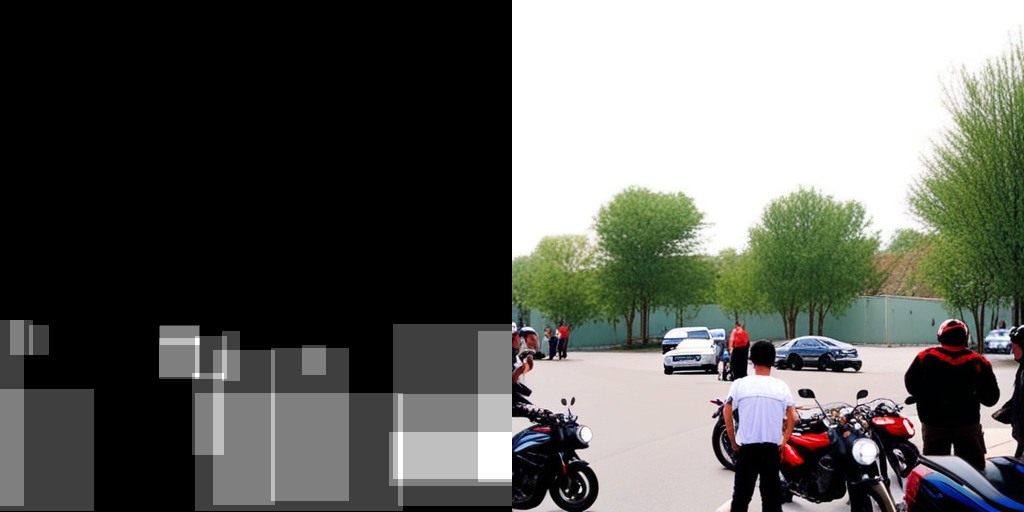

In [7]:
seed = 42
maxex = 5
device = pipe.device


generator = torch.Generator(device=device)
if seed is not None:
    generator = generator.manual_seed(seed)
images = []
cond_images = []
captions = []


i = 0
while i < maxex:
    example = ds[i]
    images.append(
        pipe(prompt=example["captions"][0], obj_prompts=example["seg_captions"], obj_masks=example["cond_image"][None].to(device), 
                num_inference_steps=20, generator=generator, height=512, width=512).images[0])
    # cond_images.append(transforms.ToPILImage()(masktensor_to_colorimage(example["cond_image"])))
    sumimg = example["cond_image"].float().sum(0, keepdims=True)
    cond_images.append(transforms.ToPILImage()( sumimg / sumimg.max()))
    captions.append(example["captions"][0])
    print(i, captions[-1])
    print([x for x in example["seg_captions"] if x is not None])
    display(make_image_grid([cond_images[-1], images[-1]], 1, 2))
    i += 1
    if i >= maxex:
        break

0
A person standing by a stove in a kitchen.


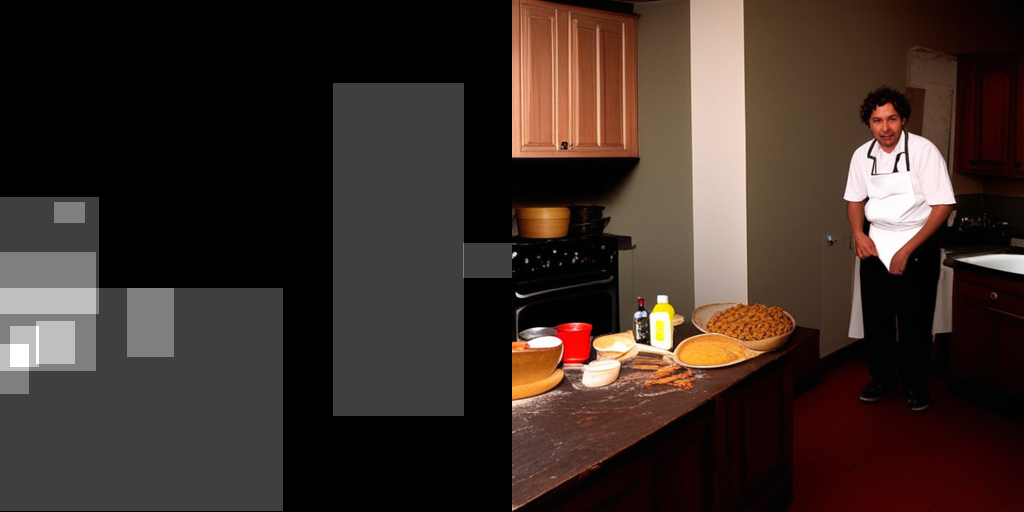

1
People walking past a homeless man begging on a city street


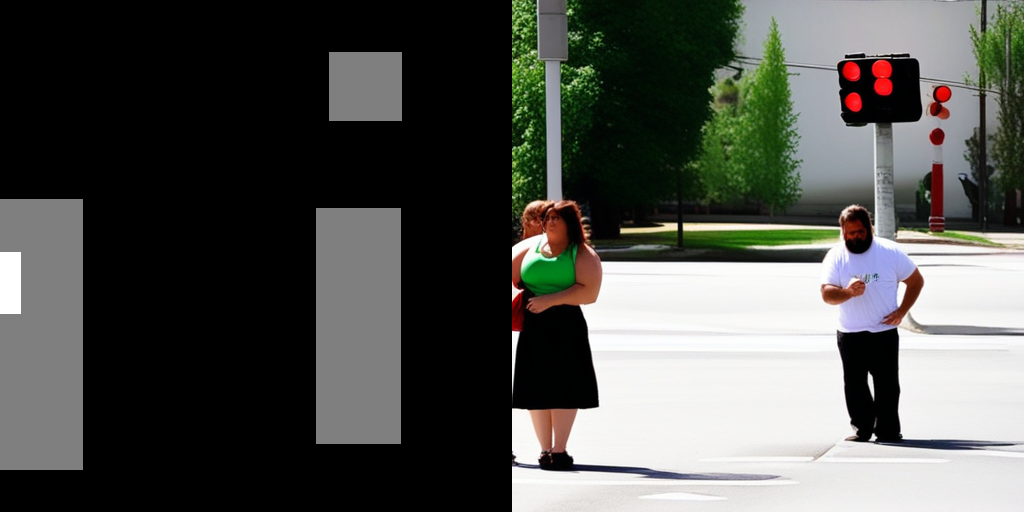

2
a bike sits parked next to a street 


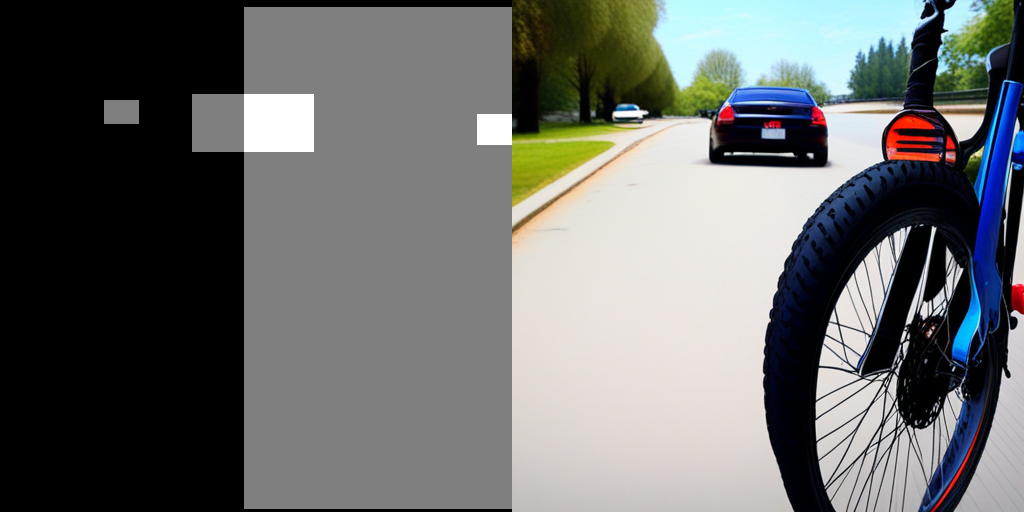

3
A row of white toilets sitting on top of a dirt ground.


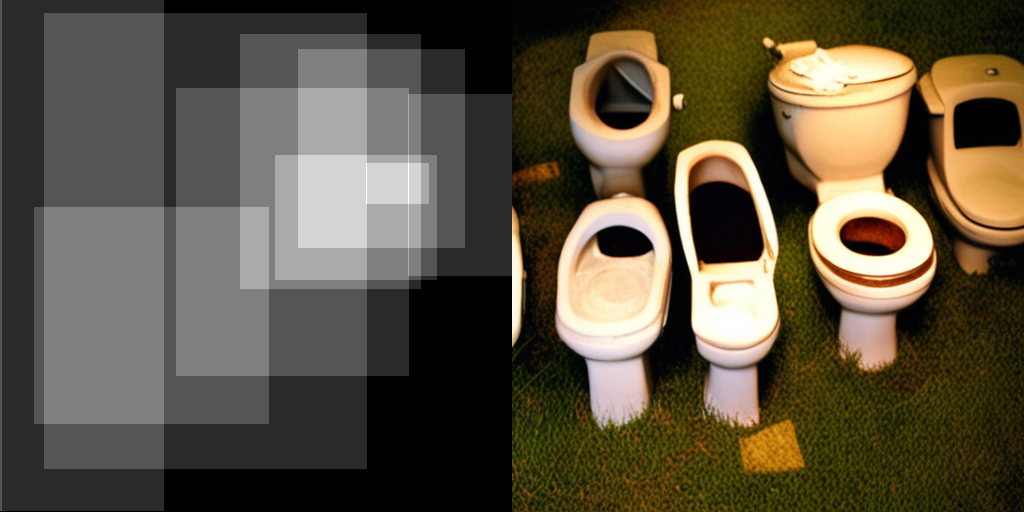

4
A bunch of bikers are gathered on a city street. 


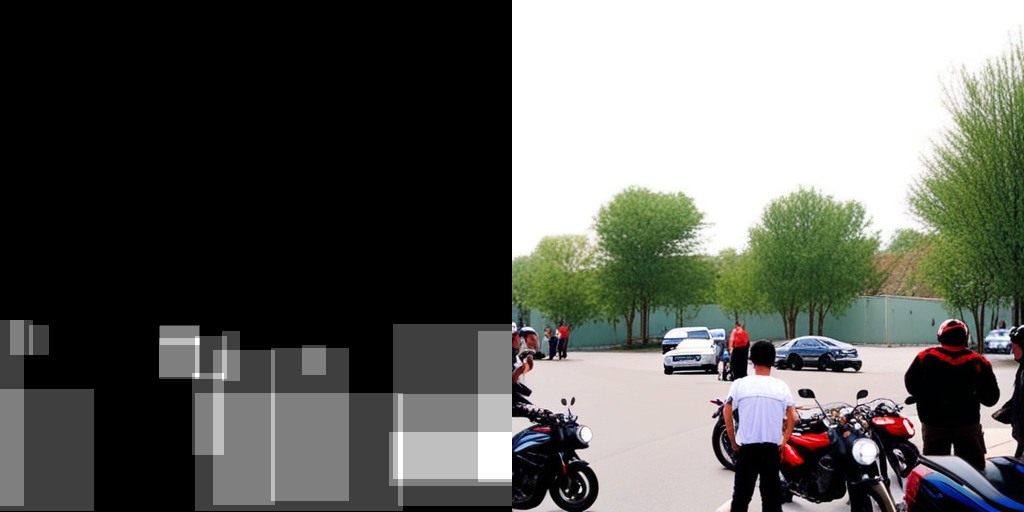

In [8]:
for i in range(len(images)):
    print(i)
    print(captions[i])
    display(make_image_grid(cond_images[i:i+1] + images[i:i+1], 1, 2))

In [9]:
# challenging cases with three balls

In [10]:
import random
import re

examples = pickle.load(open("/USERSPACE/lukovdg1/controlnet11/evaldata/extradev_importless.pkl", "rb"))
x = examples[0]
x

caption = x["captions"][0]
segten = (transforms.ToTensor()(x["seg_data"]) * 255).to(torch.long)
segten = segten[0] + segten[1] * 256 + segten[2] * 256**2
print(segten.unique())


objmasks = torch.zeros((21,) + segten.shape).to(segten.device, torch.bool)
objlayerids = list(range(len(objmasks)))
random.shuffle(objlayerids)
captions = [None for _ in range(len(objlayerids))]
for colorid in segten.unique():
    # get mask and store in variable
    mask = segten == colorid
    layerid = objlayerids.pop(0)
    objmasks[layerid] = mask
    # get description from global dense prompt and store it
    found = re.findall(r"\{([^:]+):" + str(colorid.item()) + "\}", caption)
    assert(len(found) == 1)
    captions[layerid] = found[0]
    # print(found)
    # display(transforms.ToPILImage()(mask.to(torch.float)))
    
print(captions)
print(objmasks.shape)
print(objmasks.sum(-1).sum(-1))
    

tensor([ 3584971,  5633996,  7069951, 10236894])
[None, None, 'a wooden table', None, None, 'a gold coin', None, None, None, 'a red tennis ball', None, None, None, None, None, None, 'a blue crystal ball', None, None, None, None]
torch.Size([21, 512, 512])
tensor([     0,      0, 175502,      0,      0,   4141,      0,      0,      0,
         23821,      0,      0,      0,      0,      0,      0,  58680,      0,
             0,      0,      0])


 80%|████████  | 16/20 [00:04<00:01,  3.33it/s]

100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


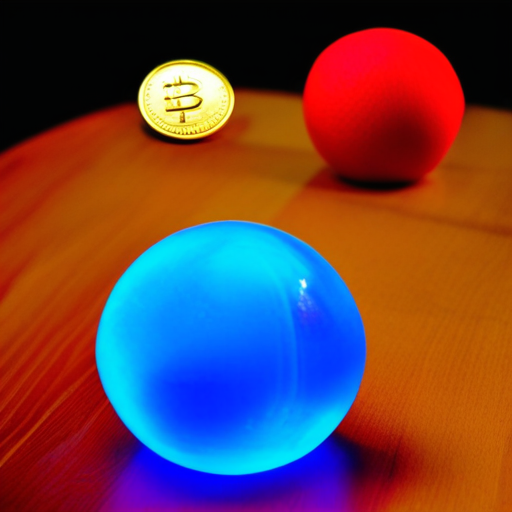

In [27]:
img = pipe(prompt="a photo of", obj_prompts=captions, obj_masks=objmasks[None].to(device, torch.long), 
                num_inference_steps=20, generator=generator, height=512, width=512).images[0]
display(img)